In [ ]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import zipfile

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path tempat dataset diunduh di Google Drive
zip_path = "/content/drive/My Drive/food-classification-burger-pizza-coke2.zip"

In [ ]:
# Ekstrak dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/food-classification")

In [ ]:
TRAINING_DIR = "/tmp/food-classification/training"
VALIDATION_DIR = "/tmp/food-classification/validation"

In [ ]:
# Fungsi untuk membagi data menjadi training dan validation, serta membuat generator data
def split_data_and_create_generators(TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    # Jika direktori training dan validation sudah ada, kosongkan isinya
    for directory in [TRAINING_DIR, VALIDATION_DIR]:
        if os.path.exists(directory):
            shutil.rmtree(directory)

    # Buat direktori training dan validation
    for directory in [TRAINING_DIR, VALIDATION_DIR]:
        os.makedirs(directory)

    # Dummy list untuk simulasi kategori
    categories = ["burger", "coke", "pizza"]

    # Direktori tempat data gambar asli berada
    gambar_asli_dir = '/content/food-classification/food-classification-burger-pizza-coke'  # Ganti dengan path sebenarnya

    for category in categories:
        # Buat subdirektori untuk setiap kategori di direktori training dan validation
        os.makedirs(os.path.join(TRAINING_DIR, category), exist_ok=True)
        os.makedirs(os.path.join(VALIDATION_DIR, category), exist_ok=True)

        category_path = os.path.join(gambar_asli_dir, category)
        files = os.listdir(category_path)

        # Bagi file menjadi training dan validation
        split_index = int(len(files) * SPLIT_SIZE)
        training_files = files[:split_index]
        validation_files = files[split_index:]

        # Salin file ke direktori yang sesuai
        for file in training_files:
            src = os.path.join(category_path, file)
            dst = os.path.join(TRAINING_DIR, category, file)
            shutil.copyfile(src, dst)

        for file in validation_files:
            src = os.path.join(category_path, file)
            dst = os.path.join(VALIDATION_DIR, category, file)
            shutil.copyfile(src, dst)

        # Print jumlah data di setiap direktori
        print(f"Kategori {category}:")
        print(f"  - Jumlah data training: {len(training_files)}")
        print(f"  - Jumlah data validation: {len(validation_files)}")

    # Membuat generator data untuk training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        batch_size=32,
        class_mode='categorical',  # Sesuaikan dengan jumlah kelas dataset
        target_size=(150, 150))

    # Membuat generator data untuk validation
    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        batch_size=32,
        class_mode='categorical',  # Sesuaikan dengan jumlah kelas dataset
        target_size=(150, 150))

    return train_generator, validation_generator

In [ ]:
# Bangun model dengan tambahan layer Conv2D dan MaxPooling2D
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
# Latih model dengan model yang diperbarui
model = create_model()
train_generator, validation_generator = split_data_and_create_generators(TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE=0.8)
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Kategori burger:
  - Jumlah data training: 800
  - Jumlah data validation: 200
Kategori coke:
  - Jumlah data training: 808
  - Jumlah data validation: 202
Kategori pizza:
  - Jumlah data training: 800
  - Jumlah data validation: 200
Found 2408 images belonging to 3 classes.
Found 602 images belonging to 3 classes.
Epoch 1/15
76/76 [==============================] - 29s 310ms/step - loss: 1.0206 - accuracy: 0.4722 - val_loss: 0.9588 - val_accuracy: 0.4884
Epoch 2/15
76/76 [==============================] - 20s 260ms/step - loss: 0.8731 - accuracy: 0.5556 - val_loss: 0.7537 - val_accuracy: 0.6279
Epoch 3/15
76/76 [==============================] - 22s 288ms/step - loss: 0.7711 - accuracy: 0.6391 - val_loss: 0.7010 - val_accuracy: 0.7010
Epoch 4/15
76/76 [==============================] - 21s 280ms/step - loss: 0.7249 - accuracy: 0.6728 - val_loss: 0.6119 - val_accuracy: 0.7525
Epoch 5/15
76/76 [==============================] - 20s 266ms/step - loss: 0.6478 - accuracy: 0.7213 - val_loss

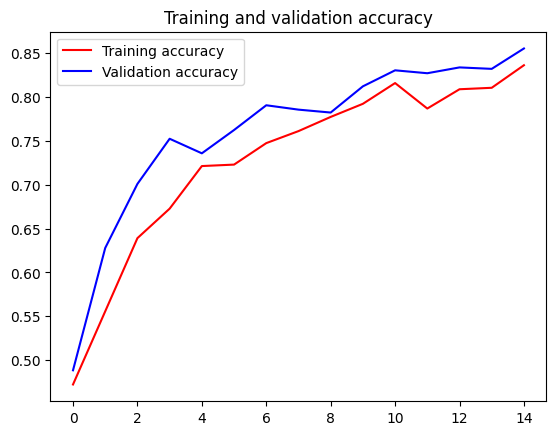

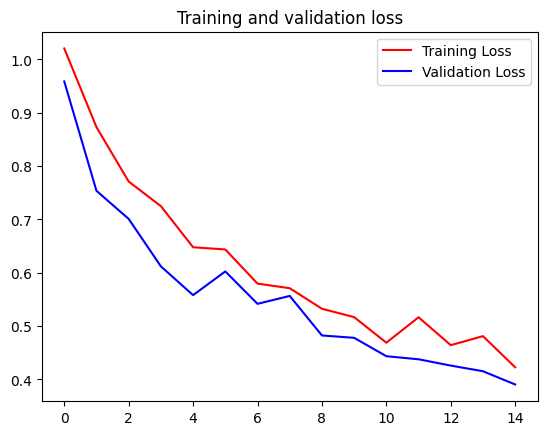

In [ ]:
# Plot akurasi training dan validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from google.colab import files

Saving cola.jpeg to cola.jpeg
User uploaded file "cola.jpeg"
1/1 [==============================] - 0s 19ms/step


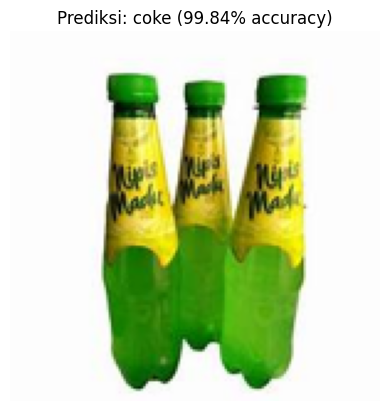

Gambar yang diupload merupakan: coke dengan akurasi 99.84%


In [ ]:
# Fungsi untuk memprediksi gambar yang diupload dan menampilkan hasil
def predict_and_show_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((150, 150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    class_indices = {0: 'burger', 1: 'coke', 2: 'pizza'}  # Sesuaikan dengan kelas yang ada pada dataset

    predicted_class = class_indices[np.argmax(prediction)]
    accuracy = np.max(prediction) * 100  # Akurasi prediksi dalam persentase

    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class} ({accuracy:.2f}% accuracy)")
    plt.axis('off')
    plt.show()

    return predicted_class, accuracy

# Unggah dan prediksi gambar
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')
    predicted_class, accuracy = predict_and_show_image(fn, model)
    print(f"Gambar yang diupload merupakan: {predicted_class} dengan akurasi {accuracy:.2f}%")


In [ ]:
# Fungsi untuk memprediksi gambar yang diupload dan menampilkan hasil
def predict_and_show_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((150, 150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    class_indices = {0: 'burger', 1: 'coke', 2: 'pizza'}  # Sesuaikan dengan kelas yang ada pada dataset

    predicted_class = class_indices[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

# Unggah dan prediksi gambar
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')
    predicted_class = predict_and_show_image(fn, model)
    print(f"Gambar yang diupload merupakan: {predicted_class}")